In [1]:
import time
import os
import torch
from torch import nn
import torch.nn.functional as F

from xgboost import XGBClassifier

import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates'

In [3]:
import model_framework
from sklearn.feature_extraction.text import TfidfVectorizer

#### Custom DataLoaders
Use classes and functions created in model_framework.py to frame out 4 different models using pytorch dataloaders...

In [4]:
FEATURES = [
    "stars",
    "review_count",
    "is_open",
    "n_reviews",
    "avg_rating",
    "IR_regular",
    "IR_follow_up",
    "IR_other",
    "Chester",
    "Bucks",
    "Philadelphia",
    "Delaware",
    "Montgomery",
    "Berks",
    'Nightlife',
    'Bars',
    'Pizza',
    'Italian',
    'Sandwiches',
    'Breakfast & Brunch',
    'Cafes',
    'Burgers',
    'Delis',
    'Caterers',
    'Mexican',
    'Desserts',
    'Salad',
    'Sports Bars',
    'Pubs',
    'Chicken Wings',
    'Seafood',
    'Beer',
    'Wine & Spirits',
    'Juice Bars & Smoothies',
    'Mediterranean',
    'Gastropubs',
    'Diners',
    'Steakhouses',
    'Breweries',
    'Donuts',
    'Barbeque',
    'Cheesesteaks',
    'Middle Eastern',
    'Wineries',
    'Indian',
    'Halal',
    'Vegan',
    'Vegetarian',
    'Beer Bar',
    'Soup',
    'Sushi Bars'
    ]

In [5]:
max_features = 2000
ngram_range = (1,2)

#pick hyperparameters and metrics

train_vectorizer = model_framework.Vectorizer(
    max_features=max_features,
    ngram_range=ngram_range, 
    stop_words="english"
)

train_dataset = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/train.csv",
    features=FEATURES
)
val_dataset = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/val.csv",
    features=FEATURES
)
test_dataset = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/test.csv",
    features=FEATURES
)

train_dataset_exploded = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/train.csv",
    features=FEATURES,
    expanded=True
)
val_dataset_exploded = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/val.csv",
    features=FEATURES,
    expanded=True
)
test_dataset_exploded = model_framework.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath="data/phila/split/test.csv",
    features=FEATURES,
    expanded=True
)

In [9]:
next(iter(train_dataset))

{'text': array([0.08994794, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'labels': 0,
 'features': array([3. , 5. , 1. , 2. , 2.5, 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])}

In [10]:
train_dataset.vectorizer.get_feature_names_out()[:100]

array(['able', 'absolute', 'absolutely', 'absolutely delicious',
       'accommodate', 'accommodating', 'accompanied', 'according',
       'actual', 'actually', 'add', 'added', 'addition', 'additional',
       'advertised', 'affordable', 'afternoon', 'aged', 'ago', 'ahead',
       'air', 'airy', 'alla', 'allergies', 'allergy', 'almond', 'amazing',
       'amazing food', 'amazing service', 'amazingly', 'ambiance',
       'ambience', 'american', 'annoyed', 'answer', 'answered', 'anymore',
       'anytime', 'apart', 'apologetic', 'apology', 'app', 'apparently',
       'appears', 'appetizer', 'appetizers', 'apple', 'appreciate',
       'appreciated', 'apps', 'area', 'area excited', 'area food',
       'areas', 'aren', 'arrive', 'arrived', 'asian', 'ask', 'asked',
       'asking', 'ate', 'atmosphere', 'atmosphere food', 'attached',
       'attempt', 'attention', 'attentive', 'attentive service',
       'attitude', 'authentic', 'available', 'average', 'avocado',
       'avoid', 'aware', 'awa

#### Experimenting with WeightedRandomSampler

In [8]:
def get_sampler(dataset):
    # https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
    class_counts = dataset.labels.value_counts()
    sample_weights = [1/class_counts[i] for i in dataset.labels.values]
    sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    return sampler

In [9]:
train_sampler = get_sampler(train_dataset_exploded)
val_sampler = get_sampler(val_dataset_exploded)
test_sampler = get_sampler(test_dataset_exploded)

This made the model worse. Scraping.

#### Model Testing

In [20]:
# wrap with any params here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
TRAIN_BATCH_SIZE = 16 #16, #8
VAL_TEST_BATCH_SIZE = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset_exploded,batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset_exploded,batch_size=VAL_TEST_BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset_exploded,batch_size=VAL_TEST_BATCH_SIZE, shuffle=True)

In [21]:
def get_metrics(val_dataloader, model, include_features=False):
    model.eval()

    with torch.no_grad():
        all_preds=[]
        all_labels=[]

        for data in val_dataloader:
            # get predicted probabilities, and labels with highest probability
            if include_features is True:
                predicted_labels = model(data['text'], data['features'])
            elif include_features == "only":
                predicted_labels = model(data['features'])
            else:
                predicted_labels = model(data['text'])

            #compute argmax
            _, preds = torch.max(predicted_labels, 1)

            all_preds.extend(preds)
            all_labels.extend(data['labels'])
 
    f1 = sklearn.metrics.f1_score(y_true=all_labels, y_pred=all_preds)
    accuracy = sklearn.metrics.accuracy_score(y_true=all_labels, y_pred=all_preds)
    recall = sklearn.metrics.recall_score(y_true=all_labels, y_pred=all_preds)
    
    return f1, accuracy, recall

In [22]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=False):
 # Sets the module in training mode.
    val_f1s=[]
    val_accuracies=[]
    val_recalls=[]

    for n_epoch in range(epochs):

        model.train()

        for data in train_dataloader:
            if include_features is True:
                y_hat = model(data['text'], data['features'])
            elif include_features == "only":
                y_hat = model(data['features'])
            else:
                y_hat = model(data['text'])

            optimizer.zero_grad()
            loss = loss_function(y_hat, data['labels'])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        f1, accuracy, recall = get_metrics(val_dataloader, model, include_features)
        val_f1s.append(f1)
        val_accuracies.append(accuracy)
        val_recalls.append(recall)
        
        if n_epoch % 100 == 0:
            print(f'At epoch {n_epoch}: loss = {loss:.3f}, and accuracy = {accuracy:.3f}')
    return val_f1s, val_accuracies, val_recalls

In [23]:
def plot_metrics(metrics):
    f1s, accuracies, recalls = metrics
    plt.plot(range(1, len(accuracies)+1), f1s, label='f1')
    plt.plot(range(1, len(accuracies)+1), accuracies, label='accuracy')
    plt.plot(range(1, len(accuracies)+1), recalls, label='recall')
    plt.legend()

    print(f"Final values: f1 {f1s[-1]:.3f}, accuracy {accuracies[-1]:.3f}, recall {recalls[-1]:.3f}")

### Logistic Regression (Neural Net)

In [24]:
import warnings
warnings.filterwarnings('always') 

In [30]:
class LogisticRegression(torch.nn.Module):
   def __init__(self, input_dim, output_dim):
      super(LogisticRegression, self).__init__()
      self.linear = torch.nn.Linear(input_dim, output_dim)
      self.nonlinearity = nn.Sigmoid()
   
   def forward(self, x):
      z = self.linear(x)
      #z_prime = self.linear_two(z)
      y_hat = self.nonlinearity(z)
      return y_hat

In [33]:
input_dim = 2000 #vocab size
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegression(input_dim, output_dim)
epochs = 100
lr = 1e-05
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

log_regr_model_val_metrics = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0: loss = 0.695, and accuracy = 0.687


Final values: f1 0.000, accuracy 0.759, recall 0.000


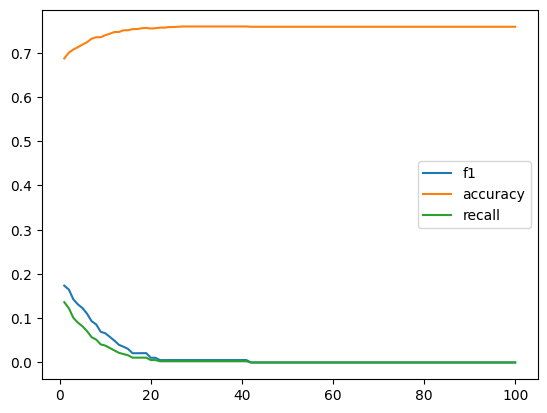

In [34]:
plot_metrics(log_regr_model_val_metrics)

In [35]:
class LogisticRegressionwithFeatures(torch.nn.Module):
   def __init__(self, input_dim, feature_dim, output_dim):
      super(LogisticRegressionwithFeatures, self).__init__()
      self.linear = torch.nn.Linear(input_dim, 2)
      self.sigmoid = nn.Sigmoid()
      self.feature_layer = torch.nn.Linear(feature_dim+2, output_dim)
      
   def forward(self, x, features):
      z = self.linear(x)
      x_prime = self.sigmoid(z)
      z_features = torch.cat((x_prime, features), 1)
      z_prime = self.feature_layer(z_features)
      y_hat = torch.sigmoid(z_prime)
      return y_hat

In [36]:
input_dim = 2000 #vocab size
feature_dim = len(FEATURES)
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegressionwithFeatures(input_dim, feature_dim, output_dim)
epochs = 200
lr = 1e-05
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies_with_features = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=True)

At epoch 0: loss = -0.634, and accuracy = 0.756
At epoch 100: loss = -0.997, and accuracy = 0.753


Final values: f1 0.016, accuracy 0.754, recall 0.008


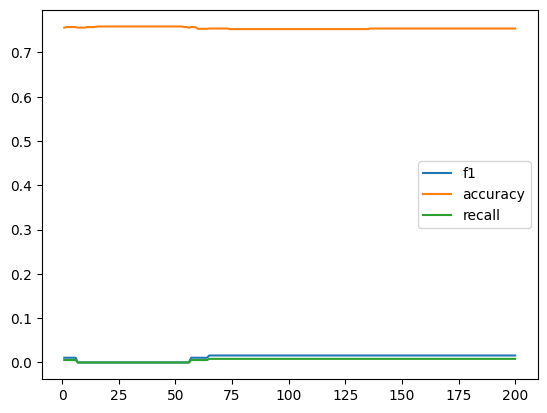

In [37]:
plot_metrics(log_regr_val_accuracies_with_features)

#### SVM

In [38]:
class SVM(nn.Module):
    def __init__(self, n_features):
        super(SVM, self).__init__()
        self.linear = nn.Linear(n_features, 2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [39]:
max_features=2000
svm_model = SVM(max_features)
epochs=100
lr = 1e-05
l1_reg = 0.01

optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr, weight_decay=l1_reg)
loss_function = nn.MultiMarginLoss()

swm_val_accuracies = train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0: loss = 0.486, and accuracy = 0.648


Final values: f1 0.000, accuracy 0.759, recall 0.000


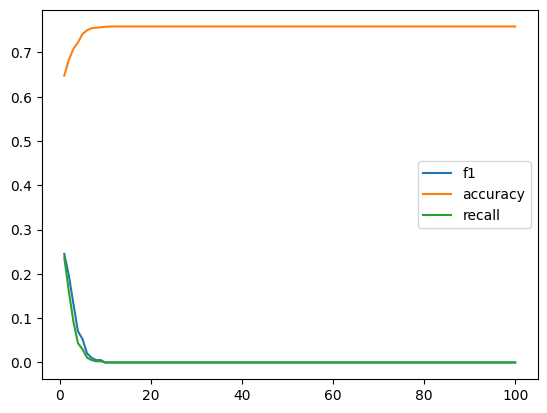

In [40]:
plot_metrics(swm_val_accuracies)

#### RNN

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
n_words = 2000
n_hidden = 10
n_categories = 2

rnn_model = RNN(n_words, n_hidden, n_categories)
epochs = 500
lr = 1e-04
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

# need to add the hidden layer to carry the context over from each batch
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
rnn_val_accuracies = train_model(rnn_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

In [146]:
from ast import literal_eval

inspections = pd.read_csv("data/phila/labeled_inspections_with_reviews.csv")

inspections['reviews'] = inspections['reviews'].apply(literal_eval)
inspections['reviews'][0]

inspections.explode("reviews").shape

(16897, 34)